# Gooogle Colab - Driver Connection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
% cd /content/drive/MyDrive/SA_IMDB/

/content/drive/MyDrive/SA_IMDB


# SA-DBLSTM

## Setup

In [3]:
!nvidia-smi

Mon Jul 18 22:12:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    38W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import Sequential
from keras import layers

In [5]:
# Load data 
train_dataset, test_dataset = tfds.load(
    'imdb_reviews', 
    split=["train", "test"],
    as_supervised=True
)

# Batches
BUFFER_SIZE = 10000
BATCH_SIZE = 128

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 1 Batch
for example, label in train_dataset.take(1):
  print(len(example))
  print('Texts: ', example.numpy()[:1])
  print('Labels: ', label.numpy()[:1])

128
Texts:  [b'13 days to Glory tells the traditional tale with sympathy toward the Mexican viewpoint. The major problem in this movie was that while cowboy actor James Arness played the part of Jim Bowie persuasively, the rest of the name actors in the cast Brian Keith (Davy Crocket) and Lorne Greene (Sam Houston) were too old.<br /><br />Raul Julia played General Antonio Lopez de Santa Anna with grace and dignity owed to the professional soldier who after all won the battle. The scene where he upbraids his officers for failing to mount a guard and prevent a sortee is one the scriptwriters did not understand. Failing to keep watch is a major remiss in the military. Santa Anna was within his prerogatives to be angry. Raul Julia magnificently carried poor writing through the scene.<br /><br />Kathleen York was an impressive Susannah Dickinson, a woman who deserves to be remembered for her courage. However, Kathleen York might have been reminded that as Dickinsons hailed from Pennsylvani

## Encoder

In [6]:
# Encoder Vocab Size
VOCAB_SIZE = 10000

# Encoder
encoder = layers.TextVectorization(VOCAB_SIZE)

# Adapt TextVectorization for Train text to sets the layer's vocabulary
encoder.adapt(train_dataset.map(lambda text, label: text))

# Vocab
encoder.get_vocabulary()[:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

Once the vocabulary is set, the layer can encode text into indices. The tensors of **indices are 0-padded to the longest sequence in the batch** (unless you set a fixed `output_sequence_length`):

## DBLSTM

### Architecture


![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

**Architecture of Bidirectional Model:**
1. This model can be build as a `Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

 This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


**Architecture of Deep Bidirectional Model:**

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://www.tensorflow.org/text/tutorials/images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer

### Model 

In [7]:
model = Sequential([
    encoder,
    layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True
        ),
    layers.Bidirectional(layers.LSTM(64, return_sequences = True)),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.3),
    layers.Dense(32, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                        

In [8]:
# Compile
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(5 * 1e-3),
    metrics='acc'
)

# Train 
history_training = model.fit(
    train_dataset, 
    epochs=4
)

Epoch 1/4
196/196 [==============================] - 52s 191ms/step - loss: 0.4618 - acc: 0.7800
Epoch 2/4
196/196 [==============================] - 39s 195ms/step - loss: 0.2986 - acc: 0.8757
Epoch 3/4
196/196 [==============================] - 38s 192ms/step - loss: 0.2144 - acc: 0.9184
Epoch 4/4
196/196 [==============================] - 38s 192ms/step - loss: 0.1304 - acc: 0.9546


In [9]:
# Evaluation
train_loss, train_acc = model.evaluate(train_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

196/196 [==============================] - 17s 89ms/step - loss: 0.3549 - acc: 0.8772


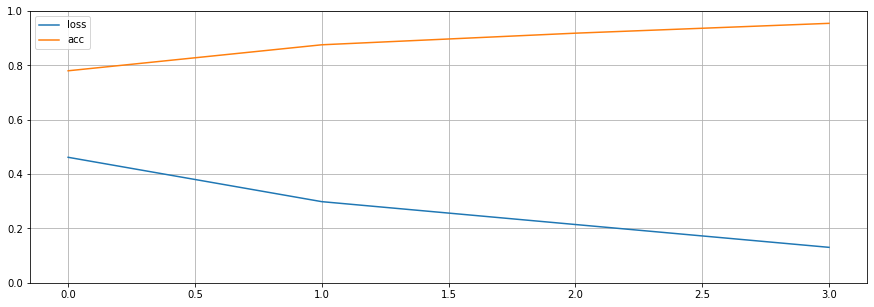

In [10]:
# Visualization
import matplotlib.pyplot as plt
pd.DataFrame(history_training.history).plot(figsize = (15,5))
plt.grid(True)
plt.gca().set_ylim(0,1);

In [11]:
# Predict
sample_text = ('The movie was cool. I would recommend this movie.')
model.predict(np.array([sample_text]))

array([[0.13588998]], dtype=float32)